In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [34]:
!unzip -q -o /kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip

In [35]:
!unzip -q -o /kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip

In [36]:
# 경로찾기
import glob
len(glob.glob("train/*"))
len(glob.glob("test/*"))

12500

In [37]:
# 이미지가 어디있는지 경로를 꼭 알아야함
# 데이터 프레임 만들기

train = pd.DataFrame({'path':glob.glob("train/*")})
train

,path
0,train/dog.8196.jpg
1,train/cat.7441.jpg
2,train/cat.2071.jpg
3,train/dog.6765.jpg
4,train/cat.8545.jpg
...,...
24995,train/cat.1594.jpg
24996,train/cat.674.jpg
24997,train/cat.127.jpg
24998,train/dog.6561.jpg


In [38]:
# 정답 칼럼 만들기
train['target'] = train['path'].apply(lambda x : x.split('/')[1].split('.')[0])
train

,path,target
0,train/dog.8196.jpg,dog
1,train/cat.7441.jpg,cat
2,train/cat.2071.jpg,cat
3,train/dog.6765.jpg,dog
4,train/cat.8545.jpg,cat
...,...,...
24995,train/cat.1594.jpg,cat
24996,train/cat.674.jpg,cat
24997,train/cat.127.jpg,cat
24998,train/dog.6561.jpg,dog


In [39]:
# 딥러닝은 파일크기가 크기 때문에 batch_size를 지정!!

In [40]:
from keras.preprocessing.image import ImageDataGenerator

idg = ImageDataGenerator()

train_generator = idg.flow_from_dataframe(train, x_col='path', y_col='target', target_size=(300,300), batch_size=32)

Found 25000 validated image filenames belonging to 2 classes.


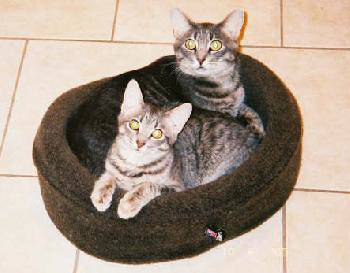

In [41]:
from PIL import Image
Image.open('train/cat.710.jpg')

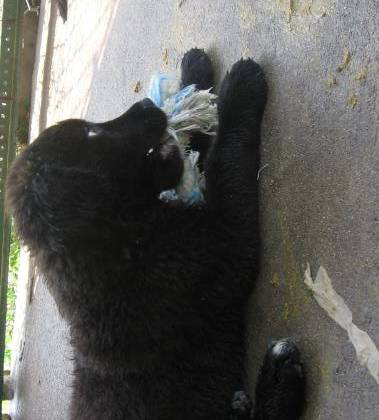

In [42]:
Image.open('train/dog.7332.jpg')

In [43]:
from keras import *
from keras.layers import *
from keras.applications.inception_v3 import InceptionV3


# # 모델 선언 (층을 쌓자!), 층을 더 업데이트 할수록 정확도 올라감
# model = Sequential()
# # 1블록
# model.add(Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3), padding='same')) # 이미지에서 특징 추출 개수 , 입력층 커널의 행렬
# model.add(Conv2D(32, (3,3), activation='relu', padding='same')) 
# model.add(MaxPool2D()) # 이미지에서 특징적인 값을 추출해줌, 모든 이미지 대회에서 쓰임
# # 2블록
# model.add(Conv2D(64, (3,3), activation='relu', padding='same')) 
# model.add(Conv2D(64, (3,3), activation='relu', padding='same')) 
# model.add(MaxPool2D())

# model.add(Flatten())
# model.add(Dense(2,activation='softmax')) # 정답층 , 정답개수
# model.summary()

# InceptionV3 모델 , 
model = Sequential()

# 옵션세가지!(가중치, 출력층 가져오지않기, 풀링옵션)
model.add(InceptionV3(weights='imagenet', include_top=False, pooling='avg')) 
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


In [44]:
# 모델 선언 마무리
model.compile(metrics=['acc'], loss='categorical_crossentropy', optimizer='adam')
model.fit(train_generator, epochs=2) # epochs 학습횟수 지정, 기본은 1

Epoch 1/2
782/782 [==============================] - 205s 252ms/step - loss: 0.2085 - acc: 0.9167
Epoch 2/2
782/782 [==============================] - 196s 251ms/step - loss: 0.0994 - acc: 0.9622


In [45]:
# 예측
test = pd.DataFrame({'path':glob.glob("test/*")})

idg2 = ImageDataGenerator()

# test_generator 만들때 옵션 두가지 더! (class_mode, shuffle=False)
test_generator = idg2.flow_from_dataframe(test, x_col='path', y_col=None, 
                                          target_size=(300,300), batch_size=32, 
                                          class_mode=None, shuffle=False)

Found 12500 validated image filenames.


In [46]:
sub = pd.read_csv('/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
sub

,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5
...,...,...
12495,12496,0.5
12496,12497,0.5
12497,12498,0.5
12498,12499,0.5


In [47]:
result = model.predict(test_generator, verbose=1)

391/391 [==============================] - 61s 153ms/step


In [48]:
result # 왼쪽이 고양이(cat)일 확률, 오른쪽이 강아지(dog)일 확률(알파벳순)

array([[9.9999905e-01, 9.8729254e-07],
       [9.9999499e-01, 4.9714454e-06],
       [1.0000000e+00, 2.6938871e-09],
       ...,
       [2.4072112e-01, 7.5927889e-01],
       [2.6589266e-03, 9.9734110e-01],
       [4.6148612e-03, 9.9538511e-01]], dtype=float32)

In [49]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

In [50]:
sub['label'] = result[:,1]
sub

,id,label
0,1,9.872925e-07
1,2,4.971445e-06
2,3,2.693887e-09
3,4,9.797717e-01
4,5,9.330071e-01
...,...,...
12495,12496,5.791845e-01
12496,12497,3.655475e-16
12497,12498,7.592789e-01
12498,12499,9.973411e-01


In [51]:
test

,path
0,test/6758.jpg
1,test/6350.jpg
2,test/8356.jpg
3,test/5180.jpg
4,test/9612.jpg
...,...
12495,test/3630.jpg
12496,test/9150.jpg
12497,test/3528.jpg
12498,test/1289.jpg


In [52]:
sub['id'] = test['path'].apply( lambda x : x.split('/')[1].split('.')[0])
sub

,id,label
0,6758,9.872925e-07
1,6350,4.971445e-06
2,8356,2.693887e-09
3,5180,9.797717e-01
4,9612,9.330071e-01
...,...,...
12495,3630,5.791845e-01
12496,9150,3.655475e-16
12497,3528,7.592789e-01
12498,1289,9.973411e-01


In [53]:
sub.to_csv('sub.csv',index=0)